In [2]:
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab10')
from sklearn import datasets
import torch
device = torch.device('cpu')
from copy import deepcopy
from sbi.neural_nets.flow import build_nsf

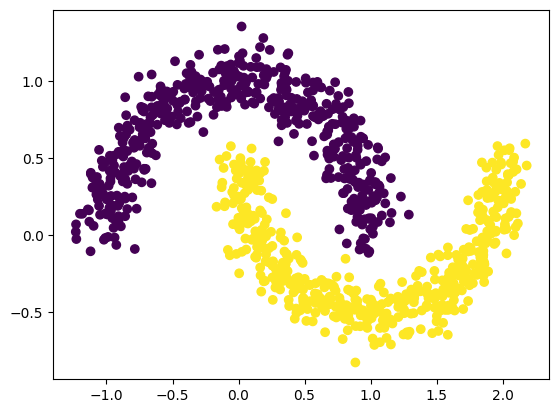

In [3]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

In [4]:
flow = build_nsf(
    batch_x=torch.Tensor(x),
    batch_y=torch.Tensor(y[:, None]),
    z_score_x='independent',
    z_score_y='independent',
    hidden_features=100,
    num_transforms=10,
    num_bins=10,
    # embedding_net: nn.Module = nn.Identity(),
    tail_bound=1.,
    # hidden_layers_spline_context: int = 1,
    num_blocks=5,
    dropout_probability=0.,
    use_batch_norm=False,
    ).to(device)

In [5]:
epochs = 1000
batch_size = 128
lr = 1e-3

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
best_epoch = 0
best_loss = np.inf

for epoch in range(epochs):    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.Tensor(x).to(device)
    y = torch.Tensor(y[:, None]).to(device)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if loss < best_loss:
        best_epoch = epoch
        best_loss = loss
        best_flow = deepcopy(flow)
        
    print(epoch, float(loss))

0 2.2429027557373047
1 2.2323646545410156
2 2.182636022567749
3 2.06718111038208
4 2.1064040660858154
5 2.129293918609619
6 2.060744285583496
7 2.0479013919830322
8 2.072178363800049
9 1.9763948917388916
10 2.0178966522216797
11 1.9916539192199707
12 1.9485700130462646
13 1.9771348237991333
14 1.958480954170227
15 1.889596700668335
16 1.9932634830474854
17 1.841142177581787
18 1.8877508640289307
19 1.8331925868988037
20 1.9477546215057373
21 1.8730188608169556
22 1.8255493640899658
23 1.8199456930160522
24 1.8429728746414185
25 1.7542827129364014
26 1.6773982048034668
27 1.7407976388931274
28 1.7327966690063477
29 1.6836061477661133
30 1.6381081342697144
31 1.7628998756408691
32 1.5520296096801758
33 1.566263198852539
34 1.597453236579895
35 1.5821818113327026
36 1.675331950187683
37 1.5695745944976807
38 1.4259732961654663
39 1.6266281604766846
40 1.4642812013626099
41 1.565098524093628
42 1.6964213848114014
43 1.626295566558838
44 1.5460560321807861
45 1.4605101346969604
46 1.6534329

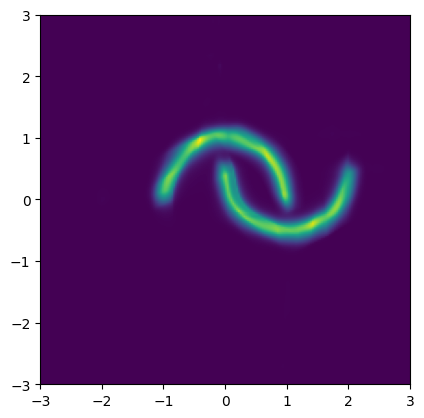

In [6]:
p = 3
n = 200

x = np.linspace(-p, p, n)
y = np.linspace(-p, p, n)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.concatenate(
    [xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],
    axis=1,
    dtype=np.float32,
    )

with torch.no_grad():
    zgrid = torch.zeros(xy.shape[0])
    for context in [0., 1.]:
        zgrid += best_flow.log_prob(
            torch.tensor(xy), torch.tensor([[context]]*xy.shape[0]),
            ).exp()#.reshape(n, n)
        
plt.imshow(
    zgrid.numpy().reshape(n, n),
    origin='lower',
    aspect='equal',
    extent=(-p, p, -p, p),
    );